In [16]:
%reload_ext autoreload
%autoreload 2
import opt
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#### Generate the dataset

In [5]:
# Generate N random points
N = 1000
split = 0.8
pts = np.random.rand(N, 2)

# Split into training and testing datasets
np.random.shuffle(pts)
train, test = {}, {}
train['x'], test['x'] = pts[:int(N*split),:], pts[int(N*split):,:]

# Generate categories with nonlinear decision boundary
x1, x2 = 0.2, 0.8
decision_bound = lambda x: -10*(x-x1)*(x-x2)

mask = pts[:, 1] > decision_bound(pts[:, 0])
pos = pts[mask]
neg = pts[~mask]
train['y'], test['y'] = mask[:int(N*split)].astype(int), mask[int(N*split):].astype(int)

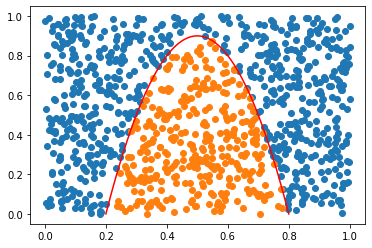

In [6]:
# Visualize dataset
plt.scatter(*pos.T)
plt.scatter(*neg.T)
xs = np.arange(x1, x2, 0.01)
plt.plot(xs, decision_bound(xs), 'r')

#### Generate random linear and nonlinear resistive networks

In [7]:
# Parameters
nodes = 20
density = 5/(nodes-1) # limit average degree to 5
denser = 0.5
diode_thresh = 3/(nodes-1) # on average each node has 1 diode
mask = np.random.uniform(0, 0.5, (nodes, nodes))
mask = mask + mask.T
con = mask < density
dense = mask < denser
diodes = mask < diode_thresh

In [8]:
# Create the linear network -- initialize random (symmetric) resistor values and apply 
# the connectivity mask
tmp = np.random.rand(nodes, nodes)
lin_network = (tmp + tmp.T) * con

In [9]:
# Create the nonlinear network -- initialize random (symmetric) resistor values and apply 
# the connectivity mask. Then, apply the diode mask by assigning random directions to each diode.
relu_network = (tmp + tmp.T) * (dense & ~(diodes | diodes.T))
diodes_dir = tmp < tmp.T
relu_network += diodes_dir * diodes

#### Train both networks

In [10]:
node_cfg = np.concatenate((np.random.permutation([1, 1, -1] + [0]*(nodes-4)), [0]))

In [17]:
# Train linear network
opt.train(lin_network, train['x'][:50,], train['y'][:50,None], node_cfg, epochs=10, nu=0.5)

TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [178]:
# Train nonlinear network
opt.train(relu_network, train['x'][:50,], train['y'][:50,None], node_cfg, epochs=10, nu=0.5)

array([[0.71101176, 0.93888049, 0.91492012, 0.        , 0.        ,
        0.        , 0.84838763, 1.03577613, 0.        , 1.44956369,
        0.81971207, 1.38458648, 0.        , 1.19636198, 0.        ,
        1.01918619, 0.        , 0.82733396, 0.86236378, 0.91739032],
       [0.93888049, 0.        , 0.        , 0.        , 0.        ,
        1.78683099, 0.        , 1.53575821, 1.33255913, 0.7980881 ,
        0.80187113, 0.84829403, 0.39192247, 0.64613426, 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.31522253],
       [0.91492012, 0.        , 0.        , 0.96961204, 0.64187832,
        0.        , 0.        , 0.        , 0.        , 0.06837749,
        0.        , 0.        , 0.        , 0.36121855, 0.        ,
        1.12410445, 0.        , 0.        , 0.57113587, 0.        ],
       [0.        , 0.        , 0.96961204, 0.        , 0.        ,
        0.        , 0.        , 1.67039538, 1.59921394, 0.4755729 ,
        0.        , 0.        , 1.91410177, 0

#### Compare the networks

In [179]:
# Evaluate accuracy on training data
lin_outputs = opt.inference(lin_network, train['x'], node_cfg)[:, np.argwhere(node_cfg < 0)].squeeze()
relu_outputs = opt.inference(relu_network, train['x'], node_cfg)[:, np.argwhere(node_cfg < 0)].squeeze()

In [180]:
lin_acc = np.count_nonzero((lin_outputs >= 0.5) == train['y']) / lin_outputs.size
relu_acc = np.count_nonzero((relu_outputs >= 0.5) == train['y']) / lin_outputs.size
lin_acc, relu_acc

(0.63125, 0.57)

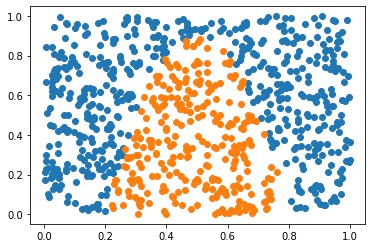

In [181]:
# Visualize the actual results
plt.scatter(*train['x'][train['y'].astype(bool)].T)
plt.scatter(*train['x'][~train['y'].astype(bool)].T)

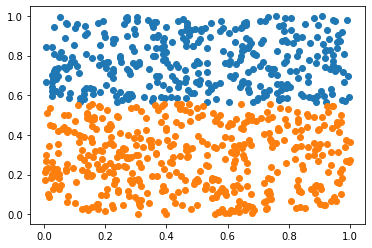

In [182]:
# Visualize linear network
plt.scatter(*train['x'][lin_outputs >= 0.5].T)
plt.scatter(*train['x'][lin_outputs < 0.5].T)

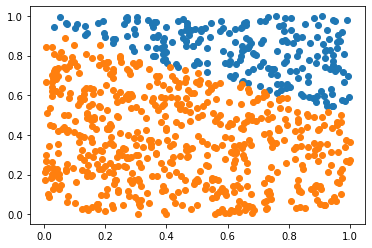

In [183]:
# Visualize relu network
plt.scatter(*train['x'][relu_outputs >= 0.5].T)
plt.scatter(*train['x'][relu_outputs < 0.5].T)

#### Compare to linear classifier

In [ ]:
cont_ftr = ['x_coord', 'y_coord']
